In [366]:
import matplotlib.pyplot as plt
import numpy as nu
from lumicks import pylake
import math
from multipletau import autocorrelate
import array
import lmfit
import scipy as sp
import numpy as np
from os import listdir
import sys, os.path
#from iRheology import *
from scipy.interpolate import interp1d
from obspy.signal.detrend import spline
from os import listdir
from os.path import isfile, join

In [367]:
def ReadTable(filename, beadindx = -1, X=0, Y=1, indx=2, skip=1):
    """ Read a table from a text file. It considers a white spaced
        text table with a filled up rectangular data set (no missing
        points in the table).

        Parameters:
        beadindx:   which column to use to factorize?
        X:          index of x coordinate
        Y:          index of y coordinate
        indx:       index of image index column 
                    (proportional to the time)

        skip:       how many lines to skip at the beginning

        Return:
        a poslist list of dicts (see ImageP track results)
        Each dict holds 'X','Y'(if any), 'indx' keys, from which
        'X','Y' are coordinate arrays, 'indx' is the image index (time).
        The position in poslist is the index of the trajectory (bead).
    """
    if os.path.isfile(filename):
        fp = open(filename, 'rt')
    else:
        print("file not found: %s" %filename) 
        return None
    
    a = fp.readlines()
    fp.close()

    #strip the skip part:
    a = a[skip:]
    Ni = len(a)
    #estimate the number of columns from the first row:
    t = (a[0].strip()).split(',')
    Nj = len(t)-1

    #Now read up the table:
    res = []
    for i in range(Ni):
        t = a[i].strip()
        
        l = []
        t = t.split(',')

        for j in range(Nj):
            if t[j+1]=='':
                continue
            l.append(float(t[j+1]))

        res.append(l)
    #end for i
    print("Found: %d lines" %len(res))

    #congvert to poslist:
    res = nu.asarray(res)
    #how many beads? beadindx is the column holding the counter:
    Nb = nu.unique(res[:,beadindx-1])
    print("Max: %d beads" %len(Nb)) 

    poslist = []
    for i in Nb:

        #bindx highlights those lines containing bead i:
        bindx = (res[:,beadindx-1] == i)
        #poslist is a list of dicts
        #each dict holds 'X', 'Y' for position arrays, 
        #and 'indx' for the image indices (may not be continuous)
        poslist.append({"X":res[bindx,X-1], "Y":res[bindx,Y-1],\
                        "indx":res[bindx,indx-1]})

    print("Found: %d beads" %len(poslist))

    return poslist
#end of ReadTable

import numpy as np
import xml.etree.ElementTree as et
 
def loadxmlTrajs(xmlfile):
    """ 
    Load xml files into a python dictionary with the following structure:
        tracks = {'0': {'nSpots': 20, 'trackData': numpy.array(t, x, y, z) }}
    Tracks should be xml file from 'Export tracks to XML file',
    that contains only track info but not the features.
    Similar to what 'importTrackMateTracks.m' needs.
    """
    try:
        tree = et.parse(xmlfile);
    except OSError:
        print('Failed to read XML file {}.'.format(xlmfile) )
    root =  tree.getroot()
    # print(root.attrib)  # or extract metadata
    nTracks = int(root.attrib['nTracks'])
    tracks = {}
    for i in range(nTracks):
        trackIdx = str(i)
        tracks[trackIdx] = {}
        nSpots = int(root[i].attrib['nSpots'])
        tracks[trackIdx]['nSpots'] = nSpots
        trackData = np.array([ ]).reshape(0, 4)
        for j in range(nSpots):
            t = float(root[i][j].attrib['t'])
            x = float(root[i][j].attrib['x'])
            y = float(root[i][j].attrib['y'])
            z = float(root[i][j].attrib['z'])
            spotData = np.array([t, x, y, z])
            trackData = np.vstack((trackData, spotData))
        tracks[trackIdx]['trackData'] = trackData
    return tracks
    # Dump the dictionary with json or pickle it as you want

def get_outlier_bounds(first_values,last_values):

    #find outliers
    sorted_f = np.sort(np.log(first_values))
    
    q1, q3= np.percentile(sorted_f,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr) 

    sorted_l = np.sort(np.log(last_values))
    
    q1, q3= np.percentile(sorted_l,[25,75])
    iqr = q3 - q1
    lower_bound_l = q1 -(1 * iqr) 
    upper_bound_l = q3 +(1.5 * iqr) 
    return lower_bound,upper_bound,lower_bound_l,upper_bound_l

In [368]:
# List the h5 files in the directory
import os
testdir = r"D:\Anurag_data\Tau condensates\Set 1\Arg-treated Tau condensates\3.30 pm\100ms_4\Complex moduli"
os.listdir(testdir)
os.chdir(testdir)
os.getcwd()

files = listdir()
scans = []
fraps=[]
for file in files:
    if '.xml' in file  :
        scans.append(file)
index = np.arange(len(scans))
insca = zip(list(index),scans)
list(insca)

[(0, '100ms_4_MMStack_Pos0_Tracks.xml')]

In [369]:
index_to_analyze =0
fname=scans[index_to_analyze]
fname=fname[0:len(fname)-4]
pos= loadxmlTrajs(fname+'.xml')

In [370]:
pixel_conversion=1
frametime= 0.1 #in seconds
R=0.1 #in microns
T = 22 #in Celsius
sizes = np.zeros((len(pos),))
for i in range(len(pos)): 
    sizes[i]=pos[str(i)]['nSpots']
lastframe=int(max(sizes))
lastframe
minframe = int(min(sizes))

In [371]:
sizes = np.zeros((len(pos),))
for i in range(len(pos)): 
    sizes[i]=pos[str(i)]['nSpots']
lastframe=int(max(sizes))
lastframe
minframe = int(min(sizes))

In [372]:
dx_all= np.zeros(int(lastframe-1),)
dy_all = np.zeros(int(lastframe-1),)
count_all = np.zeros(int(lastframe-1),)
counts=[]

for j in range(int(len(pos))):
    Vavg=0
    Xavg=0
    count=0
    dx = np.diff(pos[str(j)]['trackData'][:,1])
    dy = np.diff(pos[str(j)]['trackData'][:,2])
    time=pos[str(j)]['trackData'][:,0]


    start=int(time[0])
    end=start+len(dx)
    
    dx_all[start:end] = dx_all[start:end] + dx
    dy_all[start:end] = dy_all[start:end] + dy
    count_all[start:end] = count_all[start:end]+1
    
  
    
dx_avg=dx_all/count_all
dy_avg=dy_all/count_all


#initial position 
Xcom0=0
Ycom0=0
for key in pos:
    Xcom0 += pos[key]['trackData'][0,1]
    Ycom0 += pos[key]['trackData'][0,2]
X0 = Xcom0/len(pos)
Y0=Ycom0/len(pos)

Xcom = [X0 + sum(dx_avg[:i]) for i in range(int(lastframe))]
Ycom = [Y0 + sum(dy_avg[:i]) for i in range(int(lastframe))]

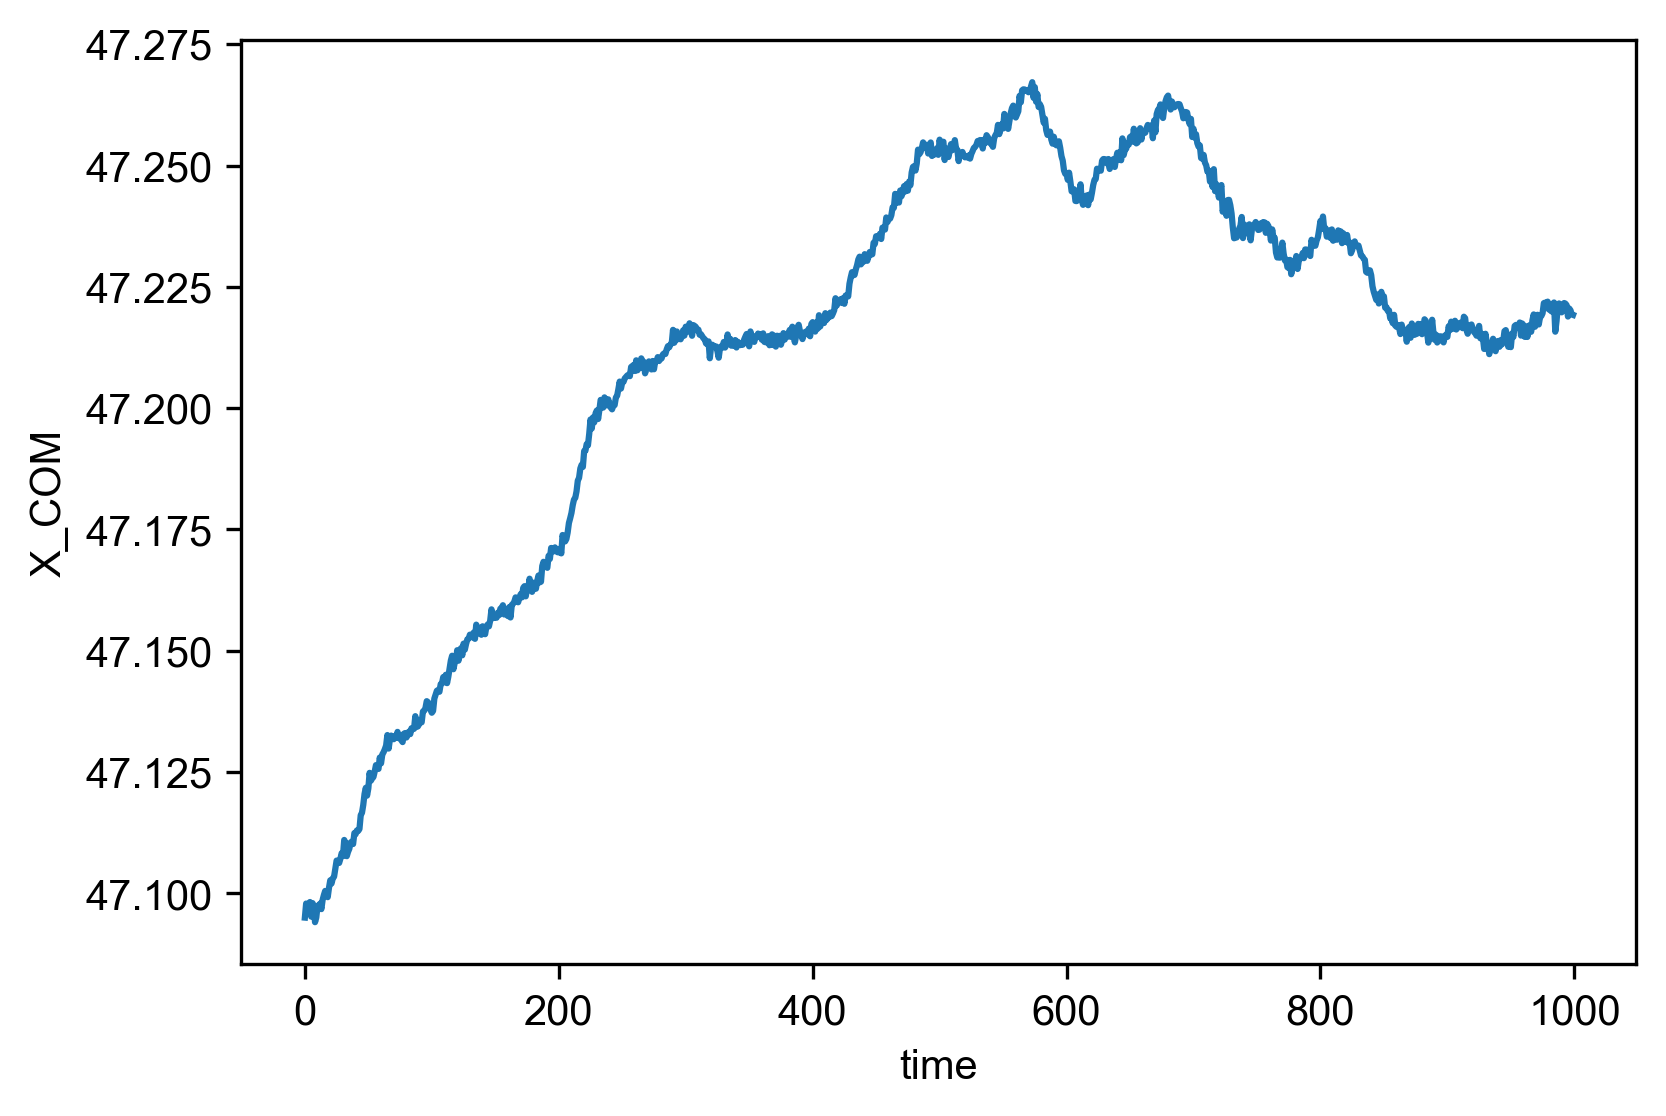

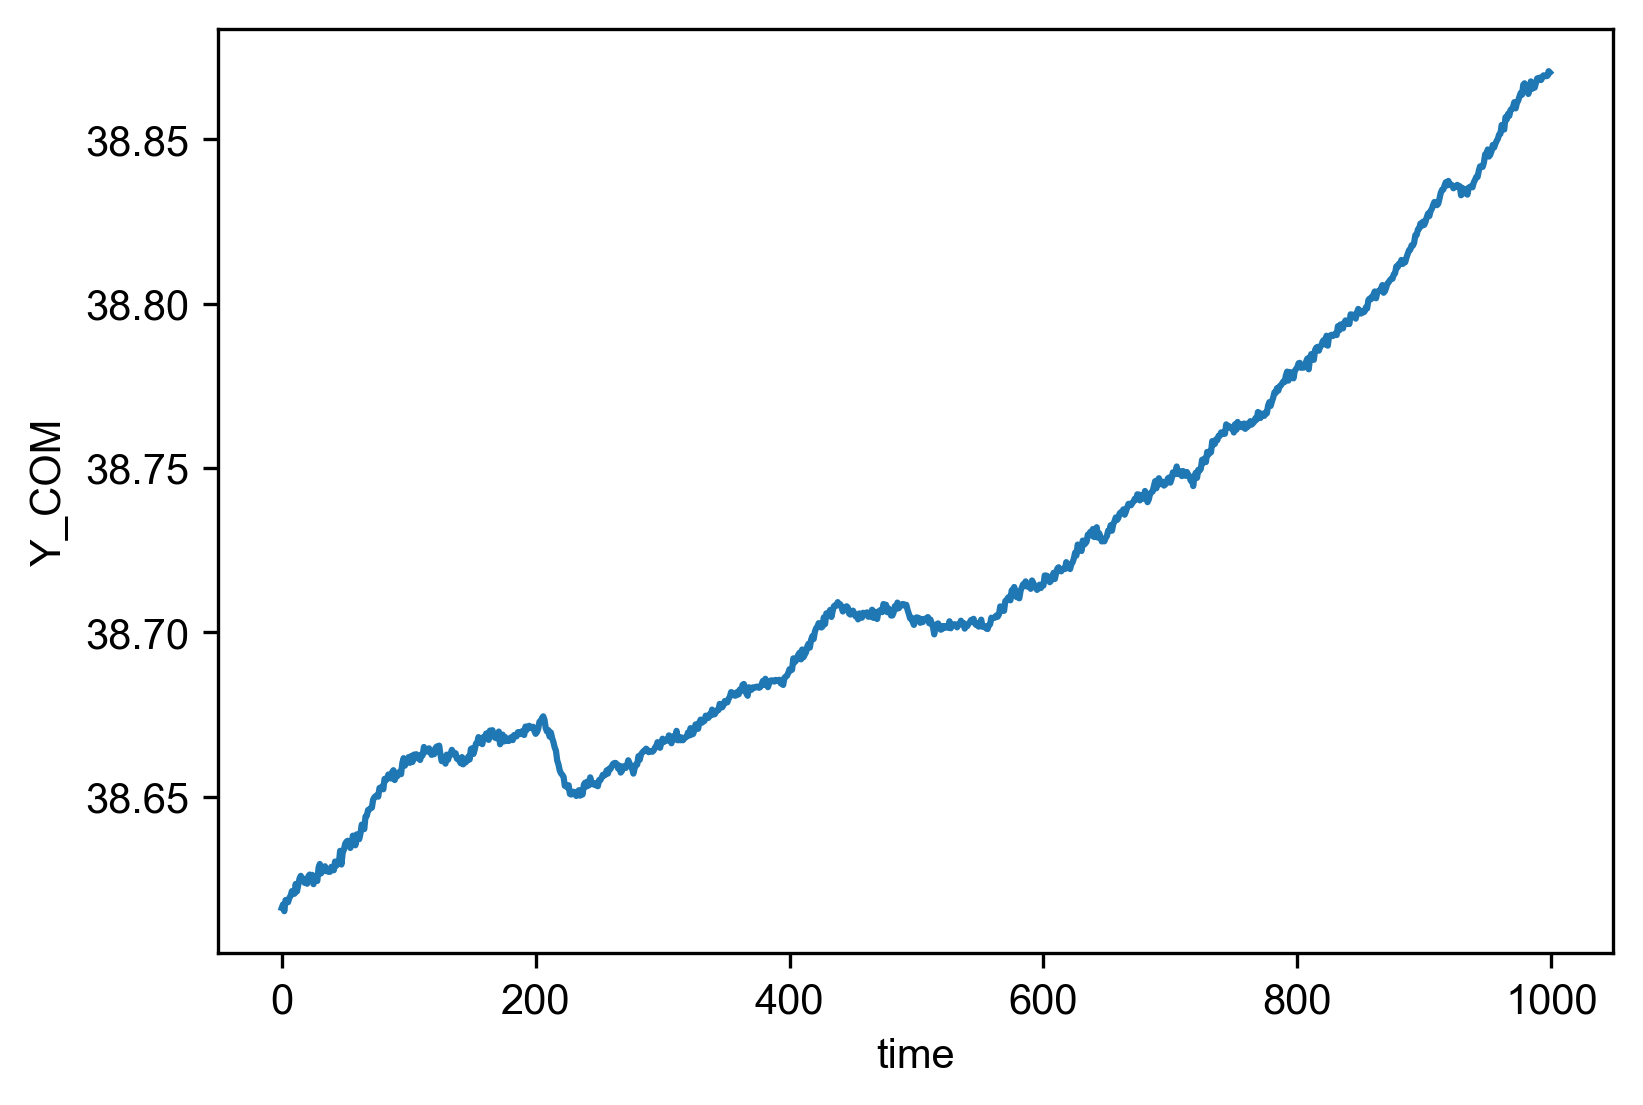

In [373]:
plt.figure(figsize=(6,4),dpi=300)
plt.plot(Xcom)
plt.xlabel('time')
plt.ylabel('X_COM')
plt.savefig(fname+'Xcom.png')
plt.figure(figsize=(6,4),dpi=300)
plt.plot(Ycom)

plt.xlabel('time')
plt.ylabel('Y_COM')
plt.savefig(fname+'Ycom.png')
fulltime = np.arange(lastframe)
np.savetxt(fname+' COM data.txt', np.transpose([fulltime,Xcom,Ycom]),delimiter='\t')

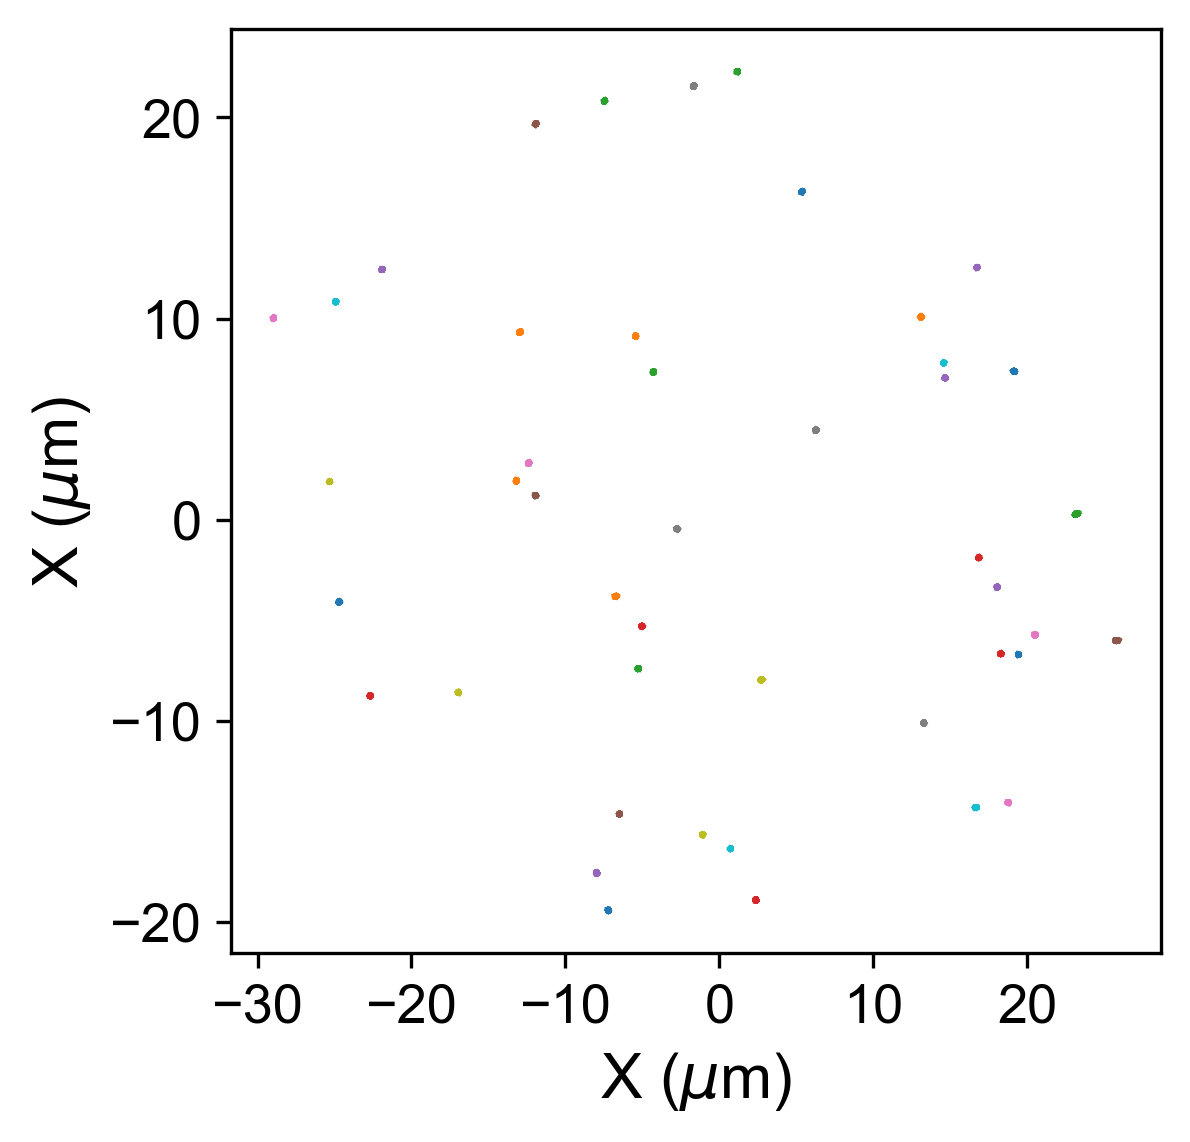

In [374]:

msds = []
xpos=[]
ypos=[]
i=[]
msdsizes=[]

first_values=[]
last_values=[]
plt.figure(figsize=(4,4),dpi=300)
plt.rcParams['font.sans-serif'] = "Arial"
for l in range(int(len(pos))):
    #ind=pos[str(l)]['indx'][0:int(lastframe)]
    start=int(pos[str(l)]['trackData'][0,0])
    xpos=pos[str(l)]['trackData'][0:minframe,1]*pixel_conversion-Xcom[start:start+minframe]
    ypos=pos[str(l)]['trackData'][0:minframe,2]*pixel_conversion-Ycom[start:start+minframe]

    #a,b=np.polyfit(ind,xpos,1)
    #error = a*ind+b
    #xpos = xpos-error 
    #a,b=np.polyfit(ind,ypos,1)
    #error = a*ind+b
    #ypos = ypos-error 
    plt.plot(xpos,ypos)
    nData = len(xpos)
    numberOfdeltaT = int(nData/4)
    msd = np.zeros((numberOfdeltaT,4))
    

    k=0
    for dt in range(numberOfdeltaT+1):
        if dt==0:
            continue
        deltax = xpos[1+dt:len(xpos)-1]-xpos[1:len(xpos)-1-dt]
        deltay = ypos[1+dt:len(ypos)-1]-ypos[1:len(ypos)-1-dt]

        sD = deltax**2+deltay**2
        msd[k,0]  =frametime*dt
        msd[k,1]  =np.mean(sD)
        msd[k,2]  =np.std(sD)
        msd[k,3]  =len(sD)
        k=k+1
    msds.append({"time":msd[:,0], "MSD":msd[:,1],"DMSD":msd[:,2], "MSDsize":len(msd)})
    msdsizes.append(len(msd))
    first_values.append(msd[0,1])
    last_values.append(msd[-1,1])
   
    xpos=[]
    ypos=[]
    i=[]

    plt.xlabel('X (um)')
    plt.ylabel('Y (um)')
plt.xlabel('X ($\mu$m)',fontsize=15)
plt.ylabel('X ($\mu$m)',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
#plt.ylim([-40,40])
#plt.xlim([0,40])
plt.savefig('tracks_all.png',bbox_inches='tight')
plt.savefig('tracks_all.svg',bbox_inches='tight')

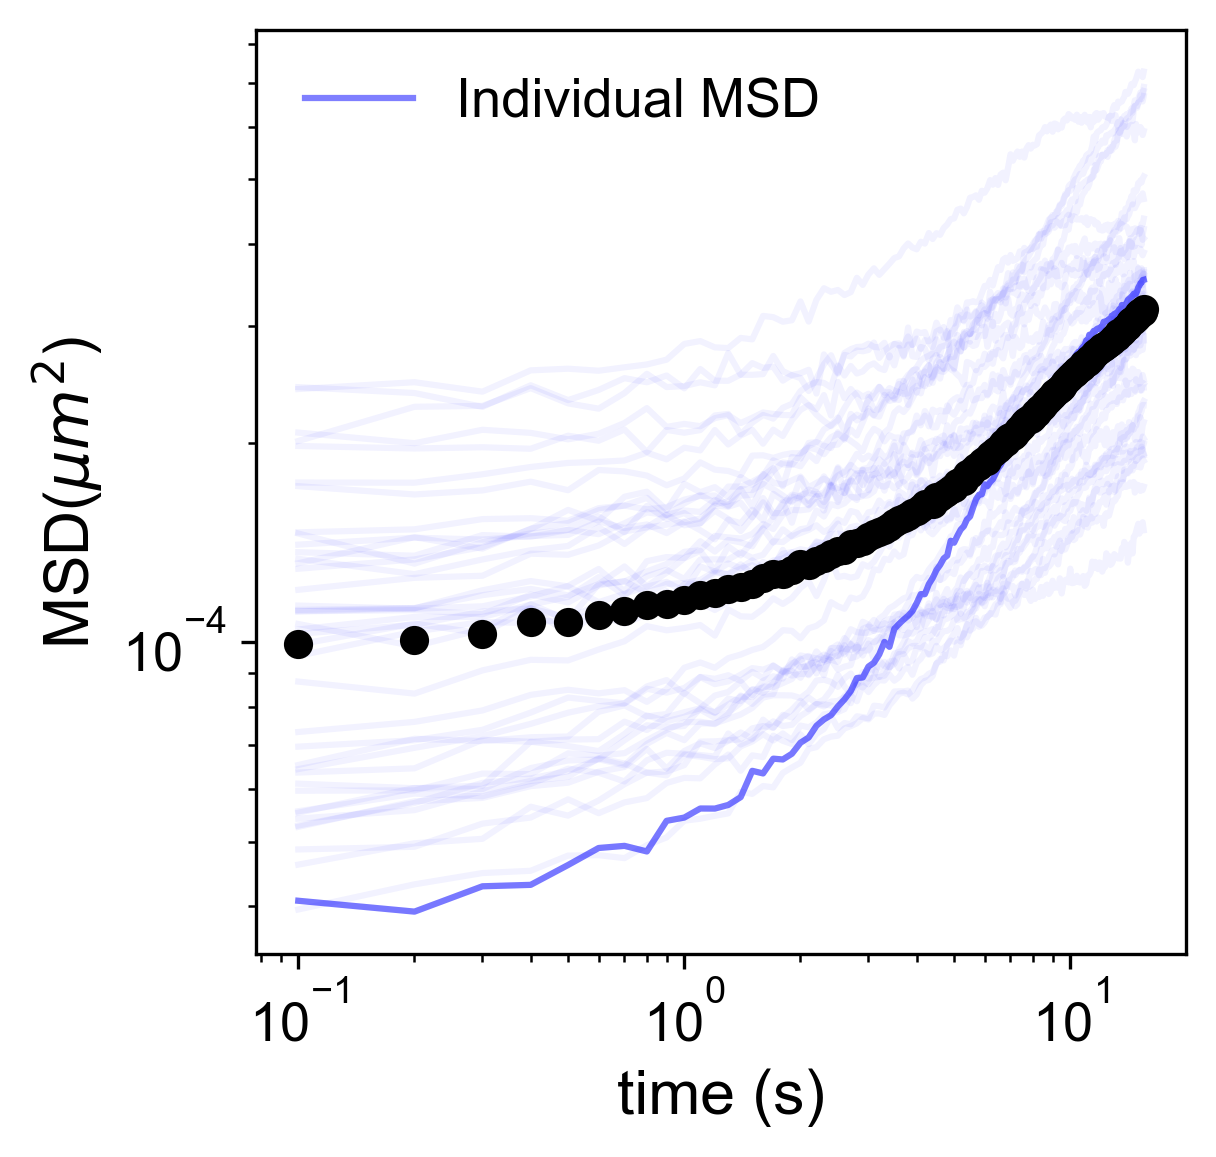

In [375]:
lower_bound,upper_bound,lower_bound_l,upper_bound_l = get_outlier_bounds(first_values,last_values)
lastind=np.min(msdsizes)-1
totmsd =np.zeros((lastind,))
msd_all=np.zeros((lastind,len(msds)))
plt.figure(figsize=(4,4),dpi=300)

plt.xlabel('time (s)',fontsize=15)
plt.ylabel('MSD($\mu m^2$)',fontsize=15)
count=0
for i in range(len(msds)):
    mmd = np.array(msds[i]['MSD'])
    time= msds[i]['time']
    if not lower_bound <np.log(mmd[0]) <upper_bound:
        continue
    if not lower_bound_l<np.log(mmd[-1])<upper_bound_l:
        continue
    #force filter
    if mmd[0]<1e-9:
        continue
    if i==2:
        plt.loglog(time[:lastind],mmd[:lastind],'blue',alpha=0.5,label="Individual MSD")
    plt.loglog(time[:lastind],mmd[:lastind],'blue',alpha=0.05)
    totmsd=totmsd+mmd[0:lastind]
    count+=1
msdavg= totmsd/len(msds)
#plt.text(min(time),max(msdavg),'N = ' + str(count)+'/'+str(len(msds)))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

#plt.loglog(time[start:end],msdavg[start:end],'ko',label="Average MSD")
#plt.loglog(time[start:end], fitresy.best_fit,'r',label="Fit")

#plt.xlim(.09,25)
plt.legend(fontsize=13, frameon=False)
plt.savefig('MSDs_all.svg',bbox_inches='tight')
time=time[0:lastind]
plt.loglog(time,msdavg,'o',color='black')
np.savetxt(fname+'MSD_new.txt',np.transpose([time,msdavg]), delimiter='\t')   # X is an array

[[Model]]
    Model(MSDfitfit)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 155
    # variables        = 3
    chi-square         = 1.1211e-09
    reduced chi-square = 7.3757e-12
    Akaike info crit   = -3970.11810
    Bayesian info crit = -3960.98783
    R-squared          = 0.99825860
[[Variables]]
    D:      4.5402e-06 +/- 1.3275e-07 (2.92%) (init = 0.2)
    alpha:  0.92087463 +/- 0.00979455 (1.06%) (init = 1)
    N:      9.5747e-05 +/- 9.7613e-07 (1.02%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, alpha) = -0.993
    C(D, N)     = -0.925
    C(alpha, N) = 0.883


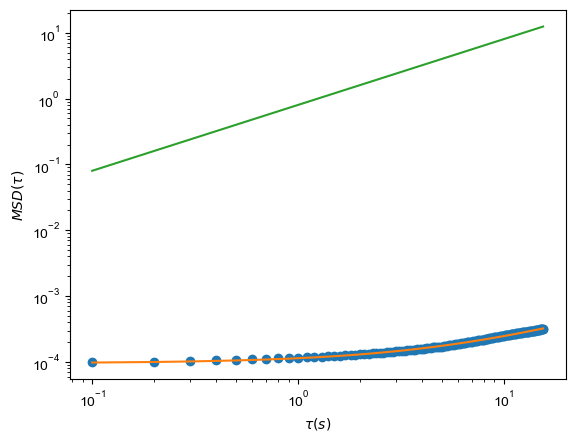

In [376]:
def MSDfitfit(t, D,alpha,N):
    return 4*D*t**alpha + N

modely = lmfit.Model(MSDfitfit)
params = modely.make_params(D=1.,alpha=1.,N=0)


params['D'].set(value=.2, vary=True)
params['alpha'].set(value=1.0, vary=True)
params['N'].set(value=0.,max=msdavg[0],min=0., vary=True)

start=0
end=500

fitresy = modely.fit(msdavg[start:end], t=time[start:end], params=params ,method='least_squares')
print(fitresy.fit_report())

plt.loglog(time[start:end],msdavg[start:end],'o')
plt.loglog(time[start:end], fitresy.best_fit)
plt.loglog(time[start:end], fitresy.init_fit)
plt.xlabel(r'$\tau (s)$')
plt.ylabel(r'$MSD(\tau)$')
plt.savefig(fname+'MSDfit.png',bbox_inches='tight')
timenew=np.logspace(-5,1,1000000)
#Jnew=modely.eval(fitresy.params,t=timenew)
np.savetxt(fname+'MSDandfit.txt',np.transpose([time[start:end],msdavg[start:end],fitresy.best_fit]))

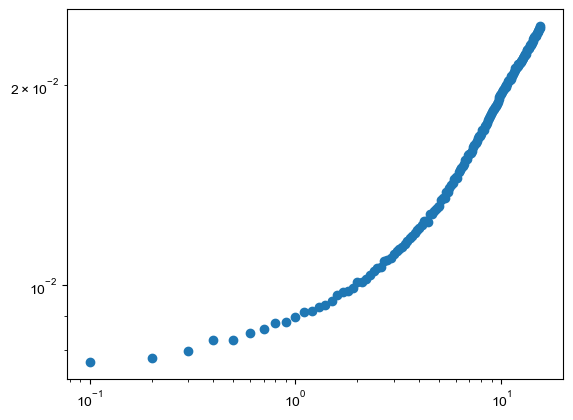

In [377]:
k_B = 1.38064852e-23 # J/K = N.m/K = Kg . m^2 /K.s^2 boltzmann const
T_k= T+273.15 # in kelvins
const = np.pi*R*1e-6/(k_B*T_k)
time1=time[start:end]
Jt=const*msdavg[start:end]*1e-12
#time1=np.logspace(-1,10,100)
#Jt = 4*time1
plt.loglog(time1,Jt,'o')

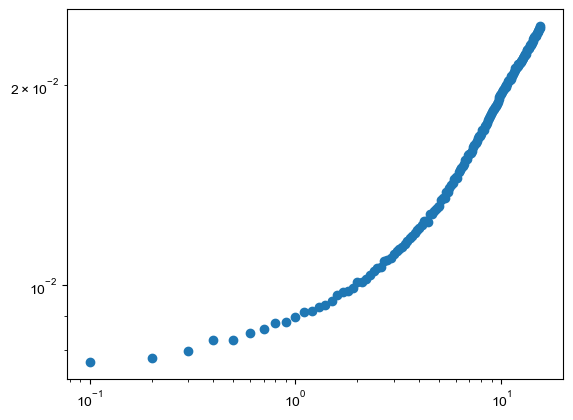

In [378]:
fsmooth = interp1d(time1,Jt, kind='cubic')
#t1=np.logspace(-1,0.6980,1000) # aged
#t1=np.logspace(-2,2,1000) # nascent
#J1= fsmooth(t1)
#plt.loglog(t1,J1)
plt.loglog(time1,Jt,'o')

In [379]:
def JtoG_IA(taunew,J,J0,eta):

        #calculate -Afreq*omega**2
    
    import math

    hpow=math.log10(1/taunew[0] )
    lpow = math.log10(1/taunew[len(taunew)-1])

    omegas=np.logspace(lpow,hpow,500)
    Jw = np.zeros(500,dtype=complex)
    Gw = np.zeros(500,dtype=complex)

    #Atimenew=[1:len(Atimenew)-1]
    #taunew=[1:len(taunew)-1]
    dA=np.diff(J)
    dt=np.diff(taunew)
   
    k=0
    for omega in omegas:
        #Afft[k]=1j*omega*g0 +(1-np.exp(-1j*omega*taunew[0]))*(Atimenew[0]-g0)/taunew[0] + gdotinf*np.exp(-1j*omega*taunew[len(taunew)-1])

        Jw[k]  =1j*omega*J0 + (1-np.exp(-1j*omega*taunew[0]))*(J[0]-J0)/taunew[0] + np.exp(-1j*omega*taunew[len(taunew)-1])/eta 
        dexp = np.diff(np.exp(-1j*omega*taunew))
        Jw[k]=Jw[k]+sum(-dexp*dA/dt)
        Gw[k]=1j*omega/Jw[k]
        k=k+1
        
    return omegas,Gw

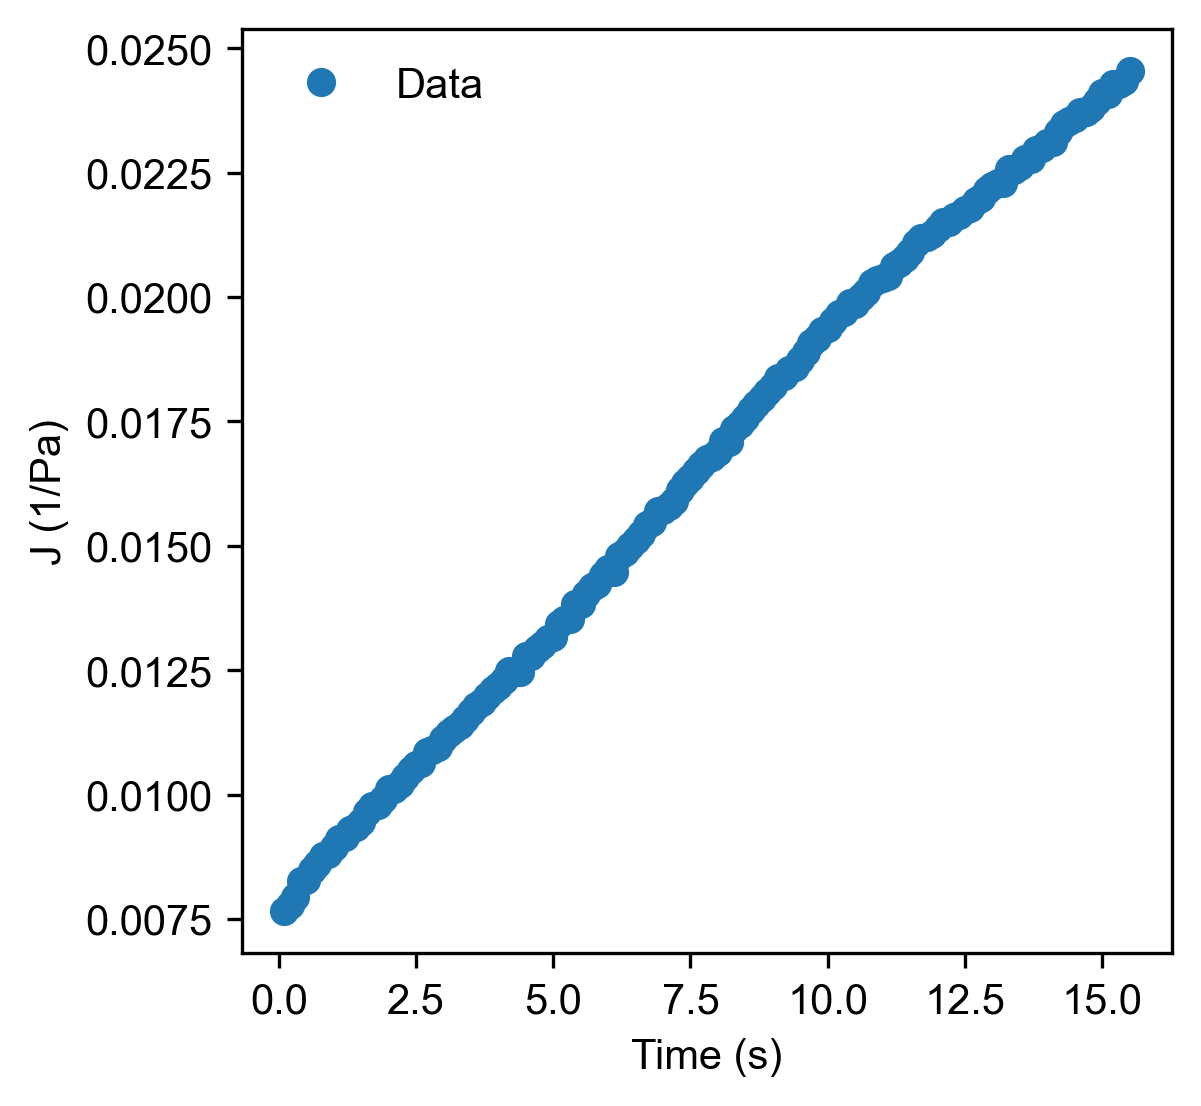

In [380]:
#M=np.loadtxt('Compliance data.txt')
#t1=M[:,0]
#J1=M[:,1]
plt.figure(figsize=(4,4),dpi=300)
plt.rcParams['font.sans-serif'] = "Arial"
plt.xlabel('Time (s)')
plt.ylabel("J (1/Pa)")

#fsmooth = interp1d(t1,J1, kind='cubic')

plt.plot(time1,Jt,'o',label='Data')
#plt.plot(t1,J1,label='interpolation')

plt.legend(frameon=False)

plt.savefig('interpolated_compliance_nascent.jpg',bbox_inches='tight')

(-0.1, 0.4)

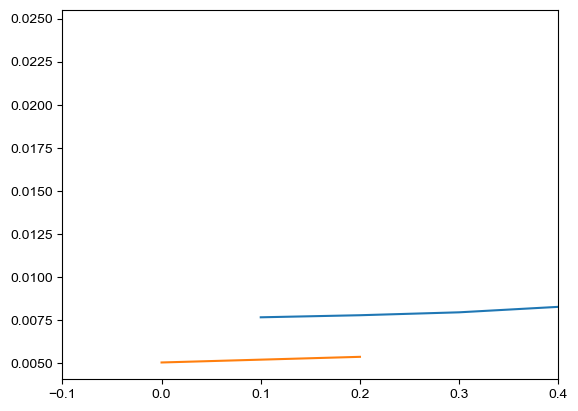

In [381]:
plt.plot(time1,Jt)
t_e=np.linspace(0,0.2,1000)
plt.plot(t_e,a*t_e+b)
plt.xlim(-.1,.4)

In [382]:
(Jt[-1]-Jt[-2])**-1*(time1[-1]-time1[-2])

515.0376961586675

In [383]:
#interpolation and getting J(0) and gradient of J at long time scales using the interpolated data
a_end,b_end=np.polyfit(time1[-100:],Jt[-100:],1)
a,b=np.polyfit(time1[:3],Jt[:3],1)
1/a_end,b

(949.3110510992777, 0.007506642481889608)

OSError: [Errno 22] Invalid argument: 'G_prime_Evans.txt'

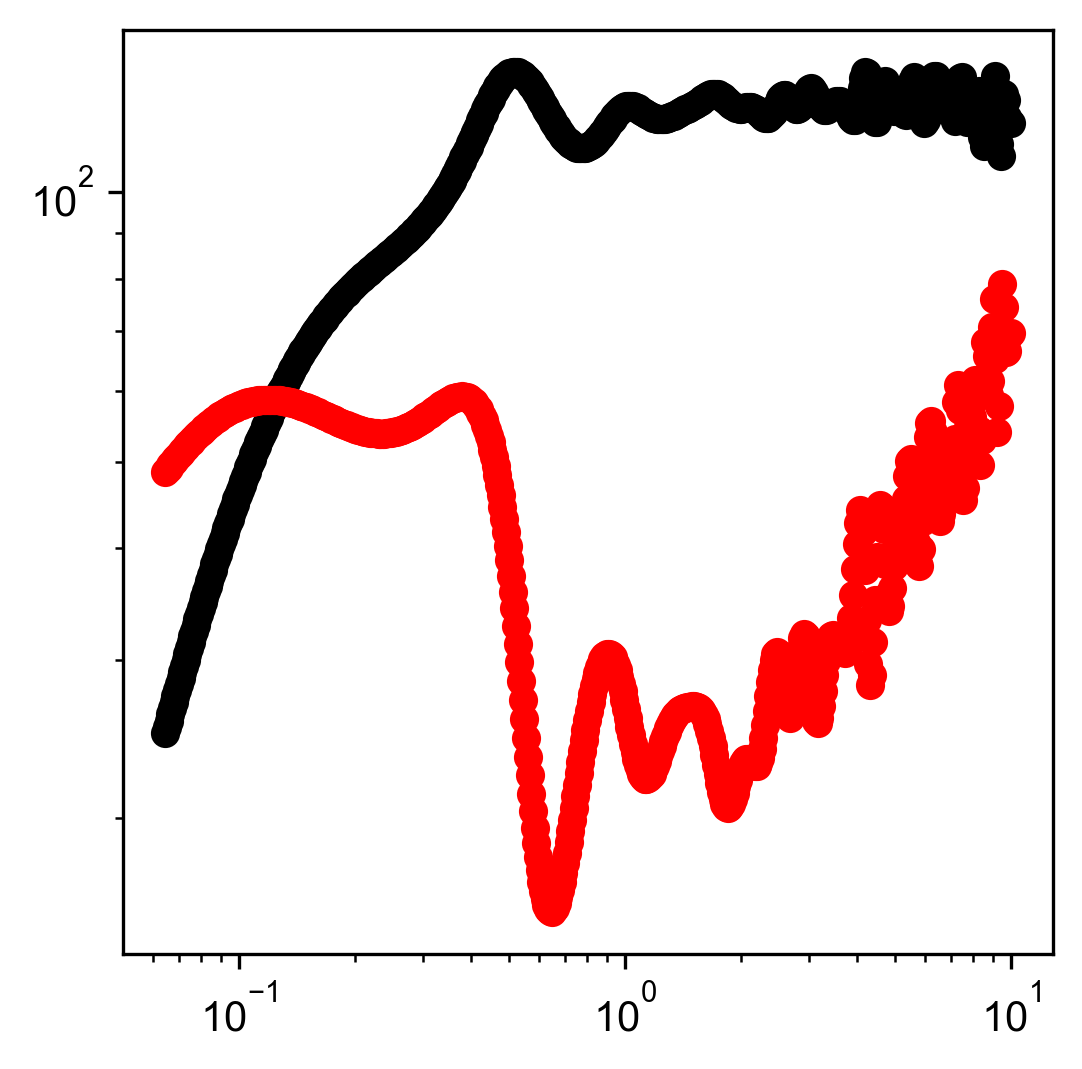

In [385]:
plt.figure(figsize=(4,4),dpi=300)
plt.rcParams['font.sans-serif'] = "Arial"
omegas,Dw=JtoG_IA(time1,Jt,0,1/a_end)
plt.loglog(omegas[::1],Dw.real[::1],'ko',label="G'")
plt.loglog(omegas[::1],Dw.imag[::1],'ro',label='G"')
np.savetxt("G_prime_Evans.txt", np.transpose(np.array([omegas[::1],Dw.real[::1]])))
np.savetxt("G_prime_prime_Evans.txt", np.transpose(np.array([omegas[::1],Dw.imag[::1]])))
plt.legend(frameon=False)
plt.xlabel('Frequency (1/s)')
plt.ylabel("G', G'' (Pa)")
plt.xlim(0.1,0.8)
#plt.text(2,.9,'Nascent condensate')
plt.savefig('Moduli_Evans.jpg',bbox_inches='tight')